In [ ]:
!pip install --upgrade pip
!pip install "tensorflow[and-cuda]"
!pip install pandas


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

In [ ]:
BATCH_SIZE = 16
EPOCHS = 50
IMAGE_SIZE = 64

In [ ]:

def remove_numbers(s):
    return s.translate(str.maketrans('', '', string.digits))

In [ ]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os 
from PIL import Image
import string


# Sao 31 imagens diferentes onde cada uma representa um canal de cor
def load_multispectral_imagem(image_dir):
    file_names = sorted(os.listdir(image_dir))
    qtd_graos = int(len(file_names)/31)
    print(f'Quantidade de graos: {qtd_graos}')

    multispectral_imgs = []

    for i in range(qtd_graos):
        images = [np.array(Image.open(os.path.join(image_dir, file))) for file in file_names[i*31:(i+1)*31]]
        multispectral_img = np.stack(images, axis=-1)   
        multispectral_imgs.append(multispectral_img)    

    return multispectral_imgs

In [ ]:
def process_path(image_dir, label):
    images = load_multispectral_imagem(image_dir)
    labels = [label]*len(images)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.uint8), tf.cast(y, tf.int32)))
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [ ]:
folder_to_label = {}
id_to_label = {}

folders = sorted(os.listdir('_recortado'))

i = -1
for folder in folders:
    keys = list(map(lambda x: remove_numbers(x), folder_to_label.keys()))
    if not remove_numbers(folder) in keys:
        i += 1
        folder_to_label[folder] = i
    else:
        folder_to_label[folder] = i

for key, value in folder_to_label.items():
    id_to_label[value] = remove_numbers(key)

print(folder_to_label)
print(id_to_label)
    
 

In [ ]:
# Enumerate retona um objeto iterável que gera uma tupla contendo um contador e os valores obtidos a partir de um iterável

def create_dataset(base_dir, folder_to_label):
    all_datasets = []

    for folder_name, label in folder_to_label.items():
        class_dir = os.path.join(base_dir, folder_name)
        dataset = process_path(class_dir, label)
        all_datasets.append(dataset)
    
    dataset = all_datasets[0]
    for ds in all_datasets[1:]:
        dataset = dataset.concatenate(ds)

    return dataset
    
dataset = create_dataset('_recortado', folder_to_label=folder_to_label)

In [ ]:
len(dataset)


In [ ]:
def preview_dataset(dataset):    
    batch_count = 0
    for images_batch, labels_batch in dataset:
        print(f'Batch de imagens shape: {images_batch.shape}')
        print(f'Batch de labels shape: {labels_batch.shape}')
        
        for image, label in zip(images_batch, labels_batch):
            qtd_canais = image.shape[-1]

            print(image.shape)    
            print(id_to_label[label.numpy() ])

            plt.figure(figsize=(64,64))
            for i in range(qtd_canais):
                image_to_show = image[..., i]
                plt.subplot(1,31,i+1)
                plt.imshow(image_to_show)
                plt.axis('off')
            plt.show()

#preview_dataset(dataset)

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    total_size = len(ds)
    train_size = int(total_size * train_split)
    validation_size = int(total_size * val_split)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)

    val_ds = remaining_ds.take(validation_size)
    test_ds = remaining_ds.skip(validation_size)
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(f'Quantidade de imagens de treino: {len(train_ds)}')
print(f'Quantidade de imagens de validação: {len(val_ds)}')
print(f'Quantidade de imagens de teste: {len(test_ds)}')

# Cache: Mantém as imagens na memória após serem carregadas do disco
# Shuffle: Mistura as imagens de treino
# Prefetch: Carrega as imagens para a GPU enquanto a GPU está ocupada
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
preview_dataset(train_ds)

In [ ]:
preview_dataset(val_ds)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),   
    layers.RandomRotation(0.2),
])

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 31) 
n_classes = len(id_to_label)
print(n_classes)


In [ ]:
for data, label in train_ds.take(10):
    print(data.shape, label)

In [ ]:
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 31)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')  # Camada de saída com softmax para n classes
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Função de perda para classificação multiclasse
              metrics=['accuracy'])


# model.summary()

# Treina o modelo
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Bandinhas - Fermentandos - Queimados - Soja - Mofados: 76%
Bandinhas - Fermentandos - Queimados - Soja: 87%
Bandinhas - Queimados - Soja: 96%

Usando 5 categorias de graos obtemos:

Epoch 50/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8190 - loss: 0.4544 - val_accuracy: 0.8936 - val_loss: 0.369

In [ ]:
model.evaluate(test_ds)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8728 - loss: 0.3489  

Text(0.5, 1.0, 'training and validation accuracy')

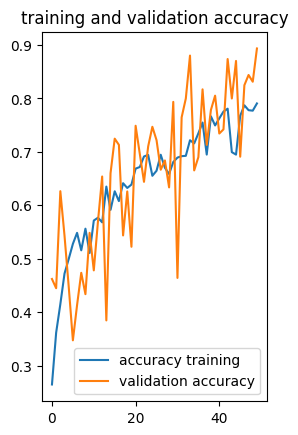

In [29]:
history.params
history.history['accuracy']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='accuracy training')
plt.plot(range(EPOCHS), val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

Text(0.5, 1.0, 'training and validation loss')

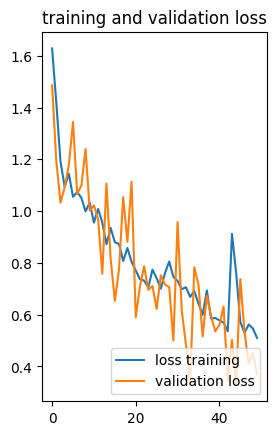

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss'] 
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='loss training')
plt.plot(range(EPOCHS), val_loss, label='validation loss')
plt.legend(loc='lower right')
plt.title('training and validation loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


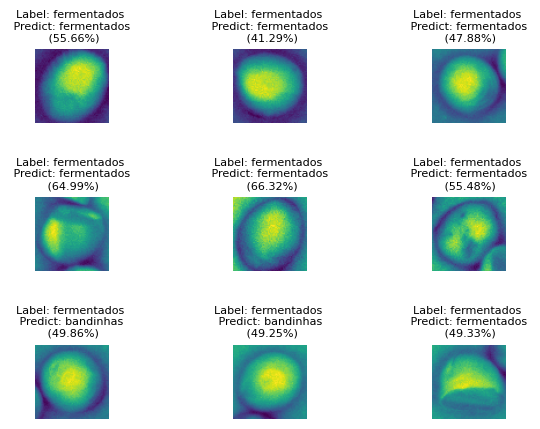

In [150]:
for images_batch, labels_batch in test_ds.take(1):    
    for i in range(9):
        plt.subplots_adjust(hspace=1, wspace=1)
        image = images_batch[i]
        label = labels_batch[i]
        
        im_to_show = image[...,0]
        batch_predict = model.predict(images_batch)

        best_predict = np.argmax(batch_predict[i])
        confidence = round(100 * (np.max(batch_predict[i])), 2)

        ax = plt.subplot(3,3, i+ 1)
        plt.imshow(im_to_show)
        plt.axis('off')
        plt.title(f'Label: {id_to_label[label.numpy()]} \n Predict: {id_to_label[best_predict]} \n ({confidence}%)', fontsize=8)
        
    

In [156]:
model.save(f"models/model{n_classes}.keras")